Import Libraries

In [122]:
# Import libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, "cleandata", "combined_personas_sample.csv")

df = pd.read_csv(
    data_path,
    low_memory=False,
    na_values=["NaN", "NA", "N/A", "", " "],
    dtype={"UPM": str}
)
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ANIO                                  80000 non-null  int64  
 1   ID_PERSONA                            80000 non-null  object 
 2   LLAVE_ENTIDAD                         80000 non-null  int64  
 3   LLAVE_MUNICIPIO                       80000 non-null  int64  
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  80000 non-null  int64  
 5   LLAVE_LOCALIDAD                       80000 non-null  int64  
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64
 7   ID_VIVIENDA                           80000 non-null  int64  
 8   ID_HOGAR                              24000 non-null  float64
 9   LLAVE_COBERTURA                       80000 non-null  int64  
 10  LLAVE_CLASEVIVIENDA                   80000 non-null  int64  
 11  LLAVE_SEXO     

In [6]:
# 1. Define continuous and categorical variables manually
continuous_vars = [
    'INGRESO', 'HORAS_TRABAJADAS', 'ESCOLARIDAD_ACUMULADA', 'ESCOLARIDAD', 'EDAD',
    'HIJOS_NACIDOS', 'HIJOS_VIVOS', 'HIJOS_FALLECIDOS'
]

categorical_vars = [
    'ANIO','LLAVE_SEXO', 'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
    'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD', 'LLAVE_SERSALUD',
    'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION', 'LLAVE_HLENGUA',
    'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA', 'LLAVE_PERTEINDIGENA',
    'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR', 'LLAVE_ENTIDAD_ASISESCOLAR',
    'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_TIETRASLADO_ESCOLAR',
    'LLAVE_MEDTRASLADO_ESCOLAR', 'LLAVE_NIVACAD', 'LLAVE_CARRERA',
    'LLAVE_ALFABETISMO', 'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A',
    'LLAVE_MUNICIPIO_RES5A', 'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL',
    'LLAVE_IDENTPAREJA', 'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
    'LLAVE_ACTECONOMICA', 'ACTIVIDAD_ECONOMICA_INEGI', 'LLAVE_PAIS_TRABAJO',
    'LLAVE_ENTIDAD_TRABAJO', 'LLAVE_MUNICIPIO_TRABAJO',
    'LLAVE_TIETRASLADO_TRABAJO', 'LLAVE_MEDTRASLADO_TRABAJO',
    'LLAVE_TAMLOC', 'ESTRATO', 'UPM', 'MERCADO_TRABAJO_LOCAL'
]

# 2. Convert types
for col in categorical_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in continuous_vars:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # ensures float

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  80000 non-null  category
 1   ID_PERSONA                            80000 non-null  object  
 2   LLAVE_ENTIDAD                         80000 non-null  int64   
 3   LLAVE_MUNICIPIO                       80000 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  80000 non-null  int64   
 5   LLAVE_LOCALIDAD                       80000 non-null  int64   
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64 
 7   ID_VIVIENDA                           80000 non-null  int64   
 8   ID_HOGAR                              24000 non-null  float64 
 9   LLAVE_COBERTURA                       80000 non-null  int64   
 10  LLAVE_CLASEVIVIENDA                   80000 non-null  int64   
 11  LL

In [7]:
# Calculate the percentage of non-null values per column
null_percentage = np.round(100 - df.notnull().mean() * 100)

# Create a DataFrame to display the results
non_null_percentage_df = pd.DataFrame(null_percentage, columns=['Percentage of Null Values'])

# Print the DataFrame
print(non_null_percentage_df.to_string())

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
CLAVE_LOCALIDAD_INEGI                                      74.0
ID_VIVIENDA                                                 0.0
ID_HOGAR                                                   70.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                        

Remove all columns with more than 10.5% missing values.

In [8]:
# Calculate the percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Filter out columns with more than 5% missing values
columns_to_keep = missing_percentage[missing_percentage <= 10.5].index

# Create a new DataFrame with only the columns to keep
df_filtered = df[columns_to_keep]

# Calculate the percentage of non-null values per column
null_percentage = np.round(100 - df_filtered.notnull().mean() * 100)

# Create a DataFrame to display the results
non_null_percentage_df = pd.DataFrame(null_percentage, columns=['Percentage of Null Values'])

# Print the DataFrame
print(non_null_percentage_df)

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
ID_VIVIENDA                                                 0.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                                            0.0
LLAVE_PAIS_NAC                                              0.0
LLAVE_ENTIDAD_NAC                       

In [9]:
# Count the number of remaining rows
remaining_cols = df_filtered.shape[1]

# Print the number of remaining rows
print("Number of remaining columns after removing those with >10% missing values:", remaining_cols)

Number of remaining columns after removing those with >10% missing values: 58


Remove all rows with missing values

In [10]:
# Remove all rows with missing values
df_cleaned = df_filtered.dropna()

# Count the number of remaining rows
remaining_rows = df_cleaned.shape[0]

# Print the number of remaining rows
print("Number of remaining rows after removing rows with missing values:", remaining_rows)

Number of remaining rows after removing rows with missing values: 65861


Using df.info() and df.describe(), describe the remaining columns.

In [11]:
# Display information about the remaining columns
df_cleaned.info()

# Display descriptive statistics for the remaining columns
df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65861 entries, 8000 to 79999
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  65861 non-null  category
 1   ID_PERSONA                            65861 non-null  object  
 2   LLAVE_ENTIDAD                         65861 non-null  int64   
 3   LLAVE_MUNICIPIO                       65861 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  65861 non-null  int64   
 5   LLAVE_LOCALIDAD                       65861 non-null  int64   
 6   ID_VIVIENDA                           65861 non-null  int64   
 7   LLAVE_COBERTURA                       65861 non-null  int64   
 8   LLAVE_CLASEVIVIENDA                   65861 non-null  int64   
 9   LLAVE_SEXO                            65861 non-null  category
 10  LLAVE_PARENTESCO                      65861 non-null  category
 11 

,LLAVE_ENTIDAD,LLAVE_MUNICIPIO,CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM),LLAVE_LOCALIDAD,ID_VIVIENDA,LLAVE_COBERTURA,LLAVE_CLASEVIVIENDA,FACTOR_EXP,EDAD,ESCOLARIDAD,ESCOLARIDAD_ACUMULADA,INGRESO
count,65861.000000,65861.000000,65861.000000,6.586100e+04,6.586100e+04,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,6.586100e+04
mean,17.728413,1077.098814,76.164969,2.610376e+06,2.012059e+15,1.030321,0.649975,7.904739,30.807640,2.982706,6.312552,7.632977e+03
std,7.885532,759.516520,99.566432,5.774933e+06,7.012302e+12,0.943294,1.090415,12.516898,20.411292,1.810090,4.669689,7.793284e+05
min,1.000000,1.000000,1.000000,0.000000e+00,2.000000e+15,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
25%,12.000000,403.000000,17.000000,0.000000e+00,2.010000e+15,0.000000,0.000000,2.000000,14.000000,2.000000,2.000000,0.000000e+00
50%,16.000000,894.000000,42.000000,0.000000e+00,2.015110e+15,1.000000,0.000000,4.000000,27.000000,3.000000,6.000000,0.000000e+00
75%,23.000000,1804.000000,95.000000,2.801390e+05,2.015302e+15,2.000000,1.000000,9.000000,44.000000,4.000000,9.000000,1.500000e+03
max,32.000000,2469.000000,570.000000,2.455004e+07,2.020321e+15,2.000000,10.000000,646.000000,110.000000,9.000000,24.000000,1.000000e+08


As we are trying to observe the evolution of the full time work income throught the years, i restrict the analysis to the population that are at working age in Mexico. Which is 18 years old.

In [12]:
# Filter individuals aged 18 or older
df_cleaned_w_age = df_cleaned[df_cleaned['EDAD'] >= 18].copy()

# Optional: check the shape
print(f"✅ Working-age dataset shape: {df_cleaned_w_age.shape}")

✅ Working-age dataset shape: (43943, 58)


And because there is a lot of dispersion in the income variable, i create the ln of income. 

In [13]:
df_cleaned_w_age['LOG_INGRESO'] = np.log1p(df_cleaned_w_age['INGRESO'])  # computes ln(1 + ingreso)

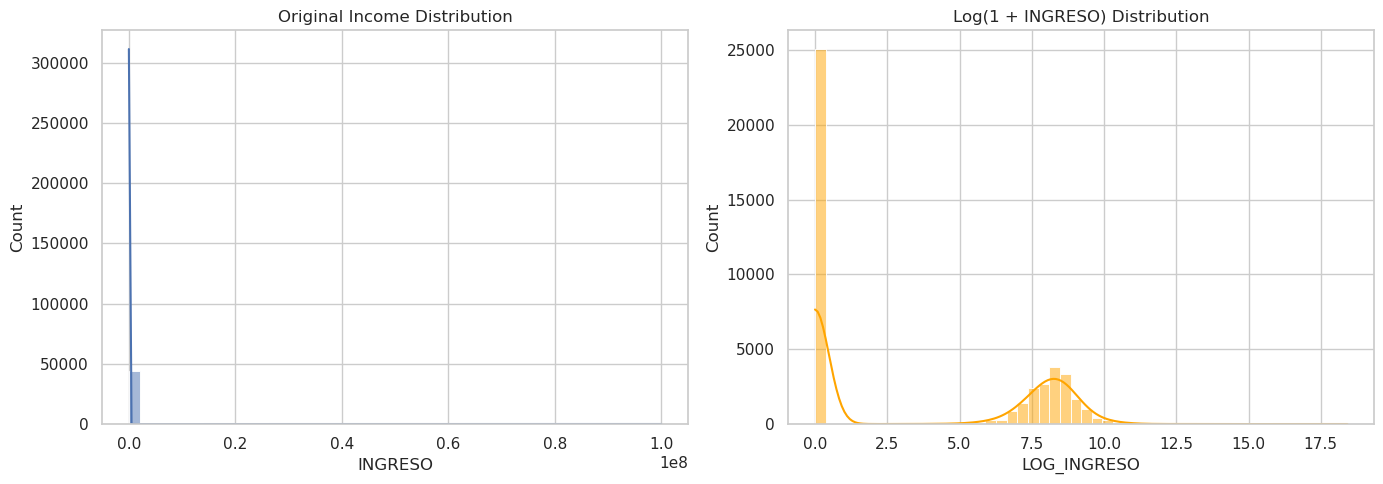

In [14]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original Income
sns.histplot(df_cleaned_w_age['INGRESO'], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Original Income Distribution")
axs[0].set_xlabel("INGRESO")

# Log Income
sns.histplot(df_cleaned_w_age['LOG_INGRESO'], bins=50, ax=axs[1], kde=True, color='orange')
axs[1].set_title("Log(1 + INGRESO) Distribution")
axs[1].set_xlabel("LOG_INGRESO")

plt.tight_layout()
plt.show()

There are a still peak around zero in INcome, which could harm the analysis. I'll limit the analysis to people that have an income greater than zero as  i want to observe how important has been education throught the years for those who have an income. 

In [15]:
# Filter first
df_positive_income = df_cleaned_w_age[df_cleaned_w_age['INGRESO'] > 0].copy()

# Then compute the log
df_positive_income['LOG_INGRESO'] = np.log1p(df_positive_income['INGRESO'])

# 🖨️ Optional: Check result
print(df_positive_income[['INGRESO', 'LOG_INGRESO']].describe())

            INGRESO   LOG_INGRESO
count  1.889000e+04  18890.000000
mean   2.647710e+04      8.155857
std    1.455029e+06      0.915890
min    2.000000e+00      1.098612
25%    2.143000e+03      7.670429
50%    3.857000e+03      8.257904
75%    6.000000e+03      8.699681
max    1.000000e+08     18.420681


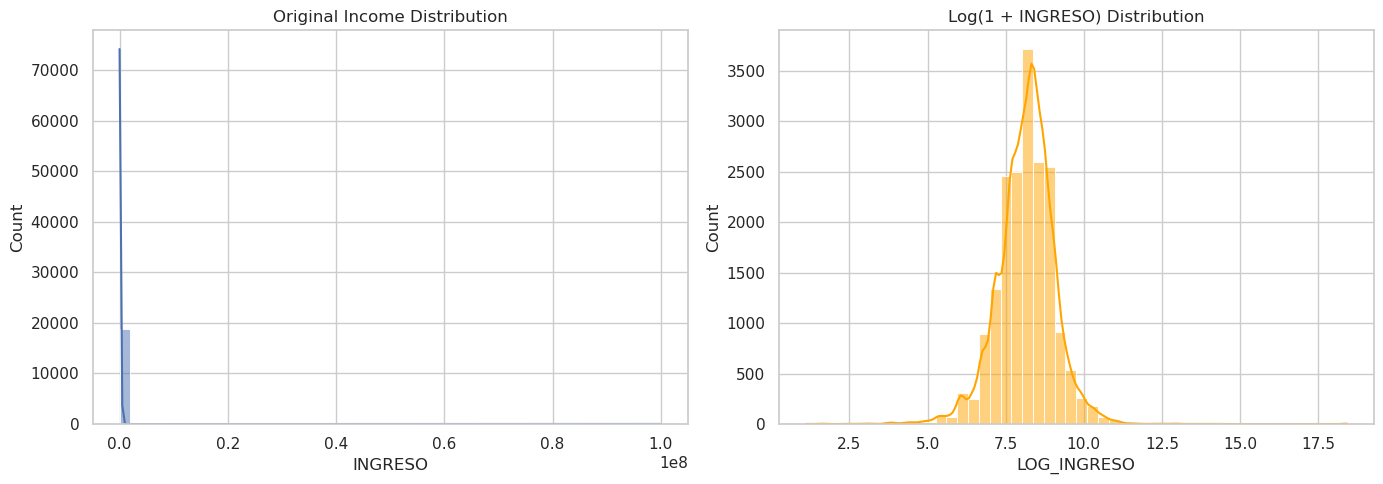

In [16]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original Income
sns.histplot(df_positive_income['INGRESO'], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Original Income Distribution")
axs[0].set_xlabel("INGRESO")

# Log Income
sns.histplot(df_positive_income['LOG_INGRESO'], bins=50, ax=axs[1], kde=True, color='orange')
axs[1].set_title("Log(1 + INGRESO) Distribution")
axs[1].set_xlabel("LOG_INGRESO")

plt.tight_layout()
plt.show()

I'll start by spliting the data in train and test sets.

In [17]:
# Define the features (X) and target (y)
X = df_positive_income.drop(columns=['INGRESO'])
y = df_positive_income['INGRESO']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17001, 58)
X_test shape: (1889, 58)
y_train shape: (17001,)
y_test shape: (1889,)


In [18]:
median = X_train["ESCOLARIDAD_ACUMULADA"].median()
print(median)

9.0


Variables Selection

In [19]:
X_train.columns

Index(['ANIO', 'ID_PERSONA', 'LLAVE_ENTIDAD', 'LLAVE_MUNICIPIO',
       'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_LOCALIDAD',
       'ID_VIVIENDA', 'LLAVE_COBERTURA', 'LLAVE_CLASEVIVIENDA', 'LLAVE_SEXO',
       'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
       'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD',
       'LLAVE_SERSALUD', 'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION',
       'LLAVE_HLENGUA', 'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA',
       'LLAVE_PERTEINDIGENA', 'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR',
       'LLAVE_ENTIDAD_ASISESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR',
       'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_MEDTRASLADO_ESCOLAR',
       'LLAVE_NIVACAD', 'LLAVE_CARRERA', 'LLAVE_ALFABETISMO',
       'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_MUNICIPIO_RES5A',
       'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL', 'LLAVE_IDENTPAREJA',
       'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
       'LLAVE_AC

Data Exploration

In [20]:
# Step 1: Concatenate X_train and y_train 
train_data = pd.concat([X_train, y_train], axis=1)
train_data.columns

Index(['ANIO', 'ID_PERSONA', 'LLAVE_ENTIDAD', 'LLAVE_MUNICIPIO',
       'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_LOCALIDAD',
       'ID_VIVIENDA', 'LLAVE_COBERTURA', 'LLAVE_CLASEVIVIENDA', 'LLAVE_SEXO',
       'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
       'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD',
       'LLAVE_SERSALUD', 'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION',
       'LLAVE_HLENGUA', 'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA',
       'LLAVE_PERTEINDIGENA', 'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR',
       'LLAVE_ENTIDAD_ASISESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR',
       'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_MEDTRASLADO_ESCOLAR',
       'LLAVE_NIVACAD', 'LLAVE_CARRERA', 'LLAVE_ALFABETISMO',
       'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_MUNICIPIO_RES5A',
       'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL', 'LLAVE_IDENTPAREJA',
       'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
       'LLAVE_AC

In [21]:
# 1) Setup
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 2) Define continuous variables
continuous_vars = [
    "EDAD", 
    "ESCOLARIDAD", 
    "ESCOLARIDAD_ACUMULADA", 
    "FACTOR_EXP", 
    "INGRESO",
    "LOG_INGRESO"
]

# 3) Define categorical variables as the remaining columns
all_columns = train_data.columns.tolist()
categorical_vars = list(set(all_columns) - set(continuous_vars))

# 4) Force types 
#train data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

#test data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

# 5) Done!
print("✅ Continuous Variables:", continuous_vars)
print("\n✅ Categorical Variables:", categorical_vars)

✅ Continuous Variables: ['EDAD', 'ESCOLARIDAD', 'ESCOLARIDAD_ACUMULADA', 'FACTOR_EXP', 'INGRESO', 'LOG_INGRESO']

✅ Categorical Variables: ['LLAVE_PARENTESCO', 'LLAVE_HLENGUA', 'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_ELENGUA', 'LLAVE_SEXO', 'LLAVE_ENTIDAD_NAC', 'LLAVE_CLASEVIVIENDA', 'LLAVE_SITTRA', 'LLAVE_MUNICIPIO', 'MERCADO_TRABAJO_LOCAL', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_CAUSAMIGRACION', 'LLAVE_HESPANOL', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPAREJA', 'LLAVE_ALFABETISMO', 'LLAVE_OCUPACION', 'LLAVE_PERTEINDIGENA', 'LLAVE_PAIS_TRABAJO', 'LLAVE_ASISESCOLAR', 'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_ACTPRIMARIA', 'LLAVE_MUNICIPIO_TRABAJO', 'LLAVE_IDENTPADRE', 'UPM', 'LLAVE_RELIGION', 'LLAVE_PAIS_RES5A', 'LLAVE_SERSALUD', 'LLAVE_ENTIDAD_TRABAJO', 'LLAVE_SITUACONYUGAL', 'LLAVE_CARRERA', 'LLAVE_REGISNAC', 'LLAVE_MEDTRASLADO_ESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_MUNICIPIO_RES5A', 'LLAVE_NACIONALIDAD', 'LLAVE_PAIS_NAC', 'ID_VIVIENDA', 'LLAVE_LOCALIDAD', 'LLAVE_PAIS_ASISESCOLAR', 'LLAVE_N

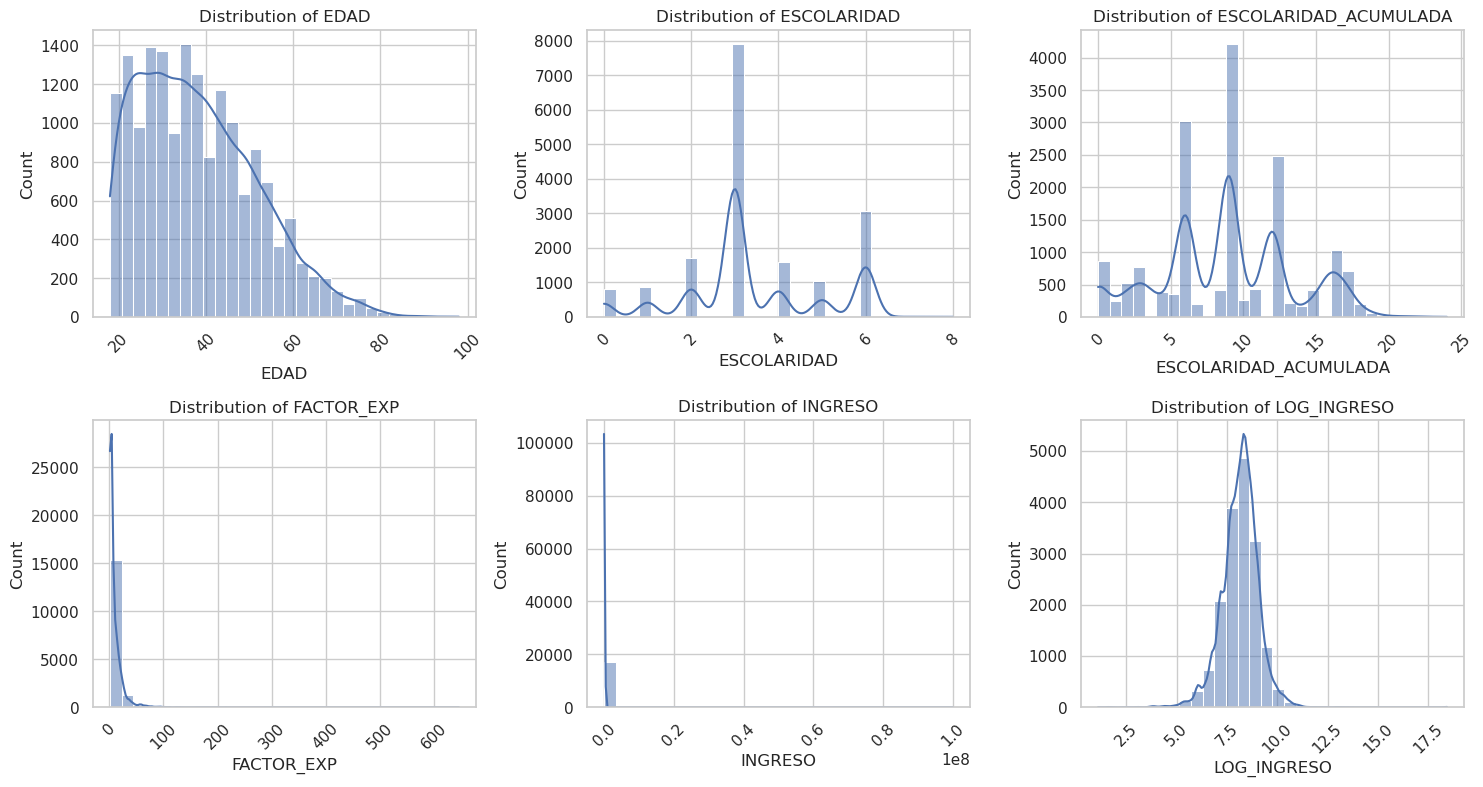

In [22]:
# 3) Plot Continuous Variables (Histograms)
n_cols = 3
n_rows = -(-len(continuous_vars) // n_cols)  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(data=train_data, x=col, ax=axs[i], kde=True, bins=30)
    axs[i].set_title(f"Distribution of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

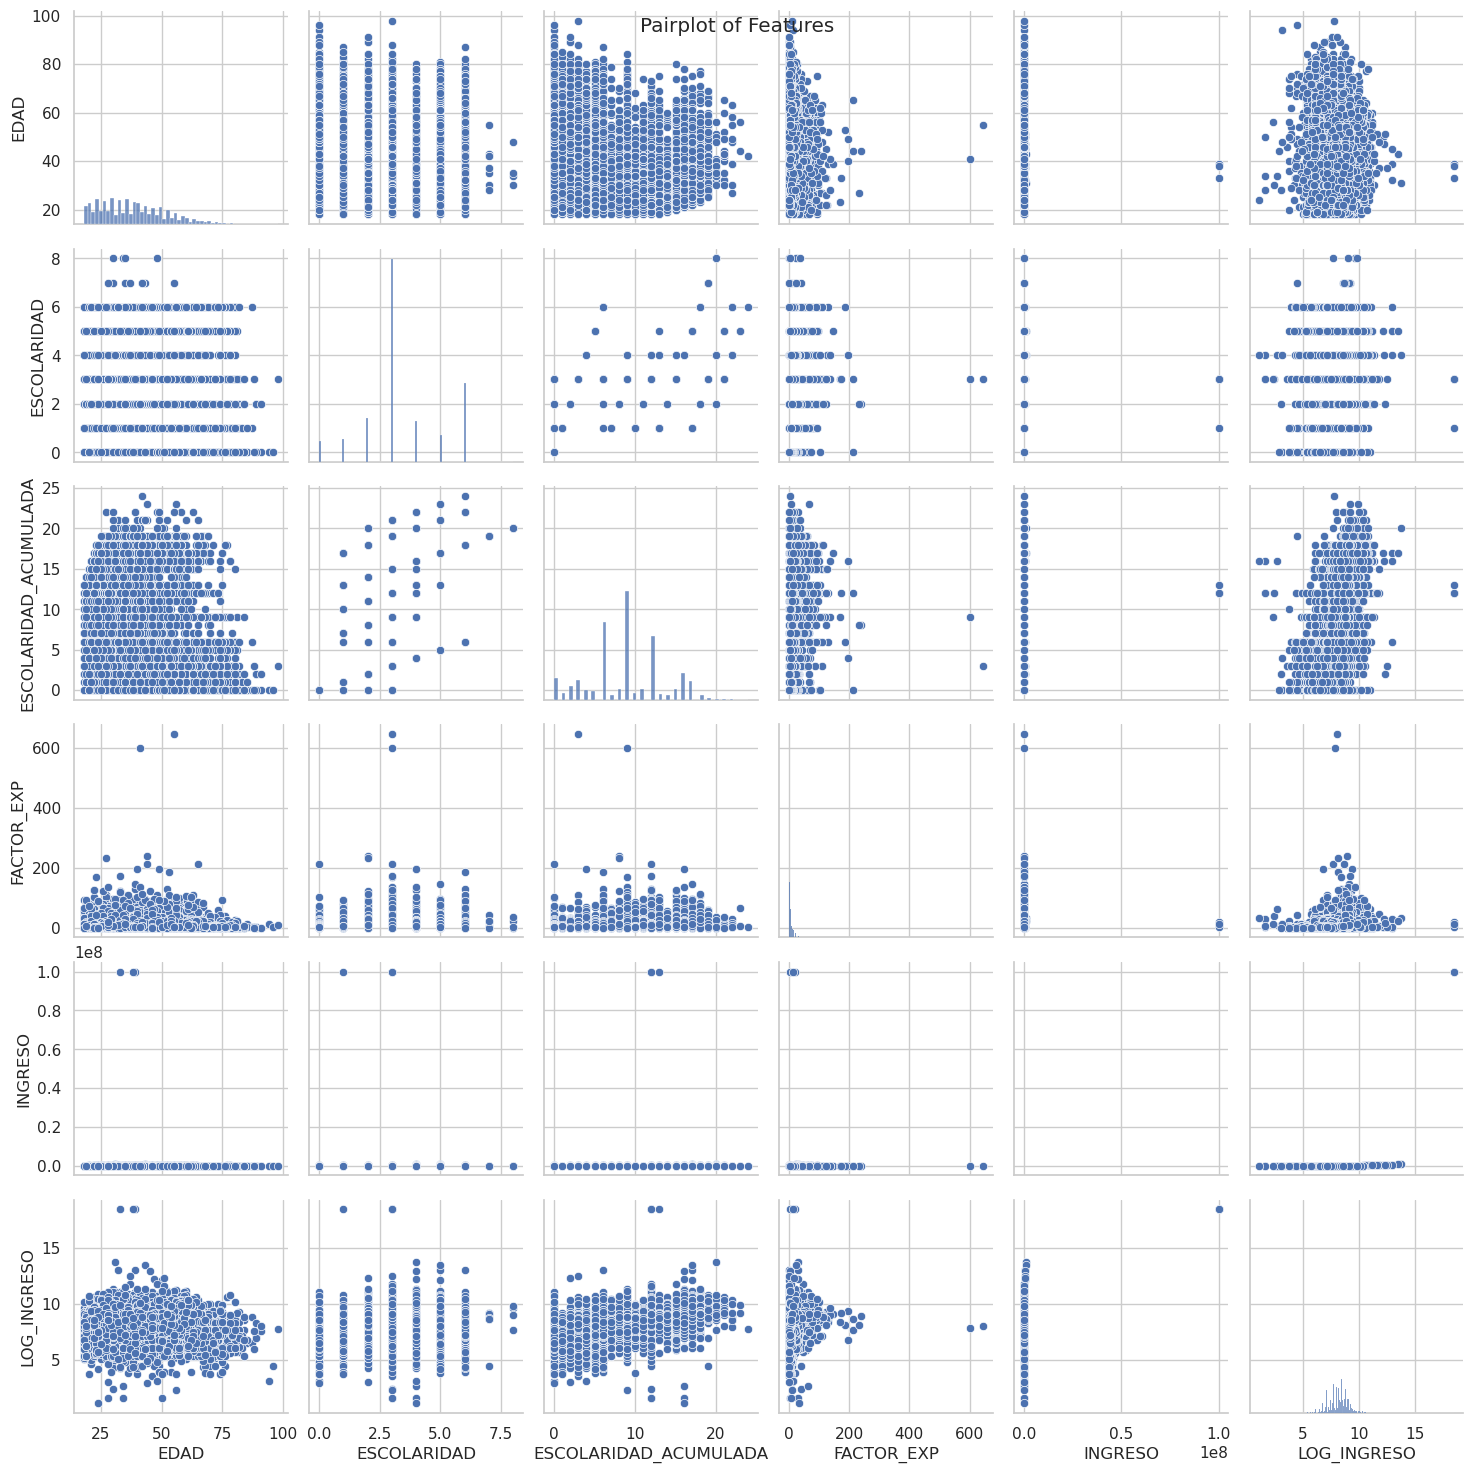

In [23]:
# Plot pairplot to visualize relationships between features
sns.pairplot(train_data[continuous_vars])
plt.suptitle("Pairplot of Features")
plt.show()

/tmp/ipykernel_3861/541619347.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


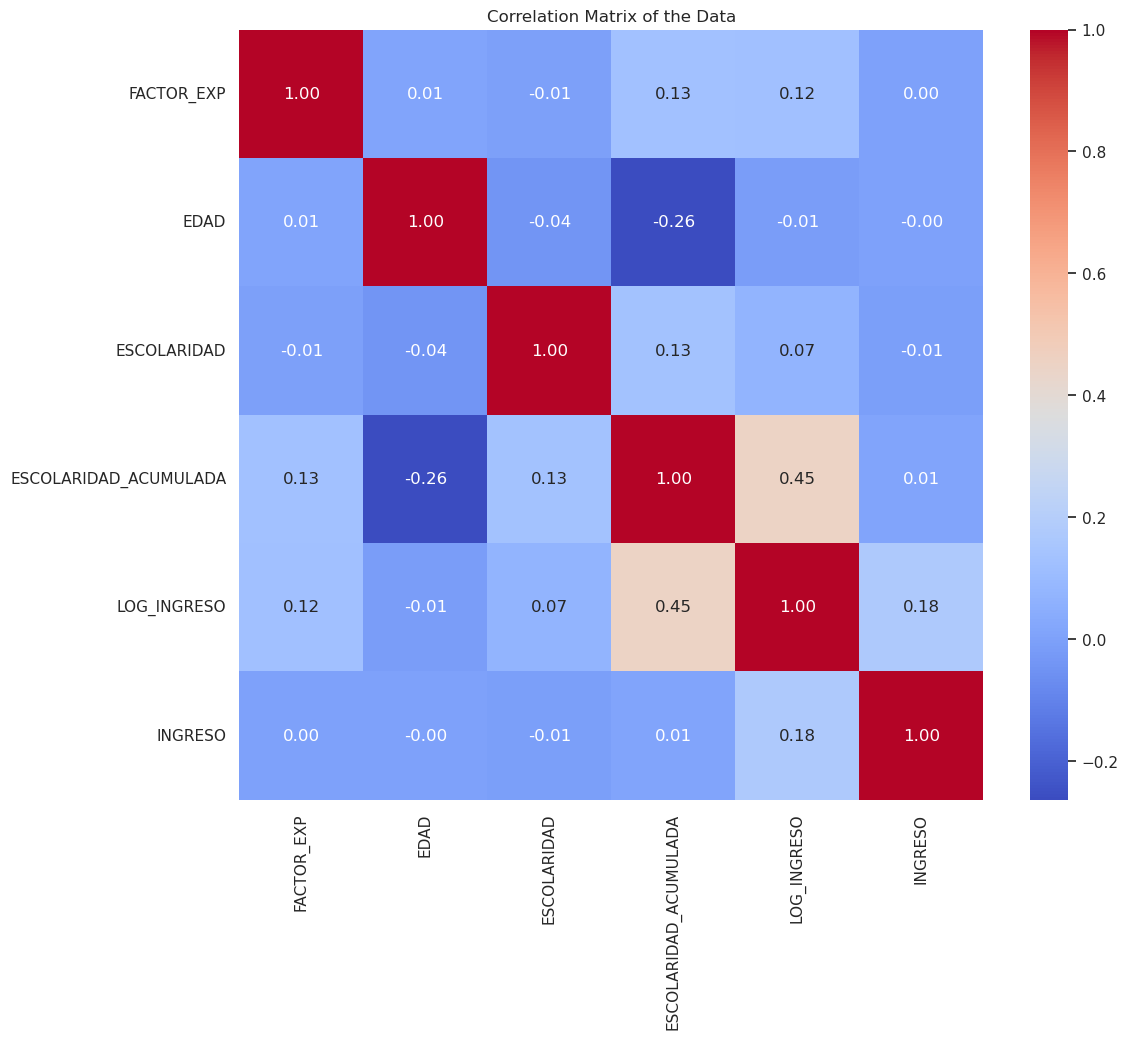

In [24]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of the Data')
plt.show()

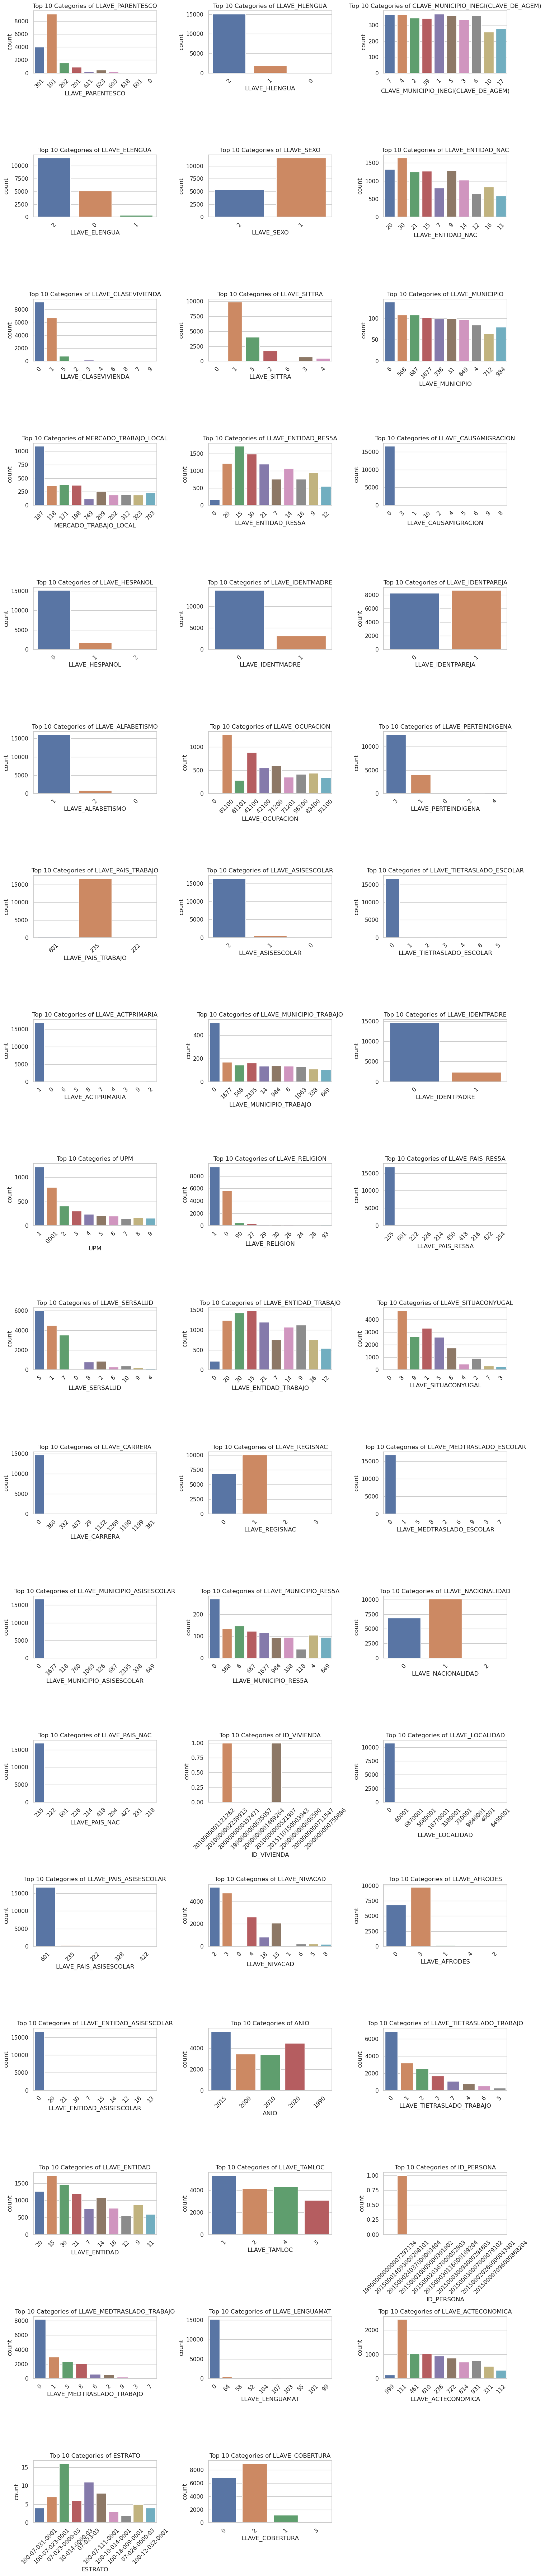

In [25]:
# 4) 4. Plot Categorical Variables (Bar Plots)

n_cols = 3
n_rows = -(-len(categorical_vars) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(data=train_data, x=col, ax=axs[i], order=df[col].value_counts().index[:10])
    axs[i].set_title(f"Top 10 Categories of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

After observing the correlation variables, I'll Prepare the Data for Machine Learning Algorithms



of all these variables that are still in the data after the exploratory phase:

# Define your variable lists
numerical_features = [
    'FACTOR_EXP',     # Expansion factor (likely continuous)
    'EDAD',           # Age
    'ESCOLARIDAD',    # Years of schooling
    'ESCOLARIDAD_ACUMULADA',  # Accumulated years of education
    'INGRESO'       # Income
]
categorical_features = [
    'LLAVE_TIETRASLADO_TRABAJO', 'LLAVE_MEDTRASLADO_TRABAJO',  
    'ANIO', 'ID_PERSONA', 'LLAVE_ENTIDAD', 'LLAVE_MUNICIPIO',
    'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_LOCALIDAD',
    'ID_VIVIENDA', 'LLAVE_COBERTURA', 'LLAVE_CLASEVIVIENDA', 'LLAVE_SEXO',
    'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
    'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD',
    'LLAVE_SERSALUD', 'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION',
    'LLAVE_HLENGUA', 'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA',
    'LLAVE_PERTEINDIGENA', 'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR',
    'LLAVE_ENTIDAD_ASISESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR',
    'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_MEDTRASLADO_ESCOLAR',
    'LLAVE_NIVACAD', 'LLAVE_CARRERA', 'LLAVE_ALFABETISMO',
    'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_MUNICIPIO_RES5A',
    'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL', 'LLAVE_IDENTPAREJA',
    'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
    'LLAVE_ACTECONOMICA', 'LLAVE_PAIS_TRABAJO', 'LLAVE_ENTIDAD_TRABAJO',
    'LLAVE_MUNICIPIO_TRABAJO', 'LLAVE_TAMLOC', 'ESTRATO', 'UPM',
    'MERCADO_TRABAJO_LOCAL'
]

i select the variables that are relevant based on: 1) theory/lit review, and 2) based on data quality. For 1, it is know in the lit that .... And for 2) even though there are a a lot of variables that have less that 10% of missing values, in many cases the category that is predominantely present corresponds to a "Not specified" which could potentially adds a lot of noise to the estimations. Having those criteria in mind, the following variables are the survivors. Also, if there are two variables that are super correlated, for example, Education and Acumulated Education, i preserve only one. 

In [26]:
# 🎯 Target Variable
target_variable = ['LOG_INGRESO']

# 🌍 Geographical / Labor Market Context
geographical_context = ['MERCADO_TRABAJO_LOCAL']  # Local Labor Market

# 📅 Temporal Variable
temporal_variable = ['ANIO']

# 🛠️ Work and Commute Characteristics
work_characteristics = [
    'LLAVE_TIETRASLADO_TRABAJO',  # Commute time to work
    'LLAVE_ACTPRIMARIA'           # Primary activity
]

# 🎓 Education
education_variables = [
    'ESCOLARIDAD_ACUMULADA',      # Accumulated schooling
]

# 🧍 Sociodemographic Characteristics
sociodemographic_variables = [
    'EDAD',                       # Age
    'LLAVE_SITUACONYUGAL',        # Marital status
    'LLAVE_PERTEINDIGENA',        # Indigenous identity
    'LLAVE_RELIGION',             # Religion
    'LLAVE_AFRODES',              # Afrodescendant identity
    'LLAVE_SEXO'                  # Sex
]

# ✅ Combine all selected variables into one list
selected_columns = (
    target_variable + 
    geographical_context +
    temporal_variable +
    work_characteristics +
    education_variables +
    sociodemographic_variables
)

# 🎯 Create a new DataFrame with only the selected variables
train_data_selected = train_data[selected_columns].copy()

# 🖨️ Optional: Check shape and preview
print(f"✅ Selected dataset shape: {train_data_selected.shape}")
train_data_selected.head(5)

✅ Selected dataset shape: (17001, 12)


,LOG_INGRESO,MERCADO_TRABAJO_LOCAL,ANIO,LLAVE_TIETRASLADO_TRABAJO,LLAVE_ACTPRIMARIA,ESCOLARIDAD_ACUMULADA,EDAD,LLAVE_SITUACONYUGAL,LLAVE_PERTEINDIGENA,LLAVE_RELIGION,LLAVE_AFRODES,LLAVE_SEXO
32134,8.630700,640,2010,0,1,12.0,43.0,8,3,1,0,2
17692,8.294300,562,2000,0,1,16.0,28.0,9,3,1,0,2
79831,8.415382,438,2020,5,1,0.0,71.0,4,1,1,3,1
43758,7.852439,65,2015,1,1,9.0,29.0,1,3,0,3,1
48856,6.754604,478,2015,6,1,9.0,24.0,1,1,0,3,2


In [27]:
train_data_selected.describe()

,LOG_INGRESO,ESCOLARIDAD_ACUMULADA,EDAD
count,17001.000000,17001.000000,17001.000000
mean,8.152509,8.845009,38.113993
std,0.914989,4.559867,13.470441
min,1.098612,0.000000,18.000000
25%,7.670429,6.000000,27.000000
50%,8.243019,9.000000,36.000000
75%,8.699681,12.000000,47.000000
max,18.420681,24.000000,98.000000


In [28]:
# Show all rows in the terminal output
pd.set_option('display.max_rows', None)

# Group by ANIO and ESCOLARIDAD_ACUMULADA and calculate average log income
avg_income_by_year_edu = train_data_selected.groupby(
    ['ANIO', 'ESCOLARIDAD_ACUMULADA']
)['LOG_INGRESO'].mean().reset_index()

# Print full output 
print(avg_income_by_year_edu)

# Optionally reset the display setting afterward
pd.reset_option('display.max_rows')

     ANIO  ESCOLARIDAD_ACUMULADA  LOG_INGRESO
0    1990                    0.0          NaN
1    1990                    1.0          NaN
2    1990                    2.0          NaN
3    1990                    3.0          NaN
4    1990                    4.0          NaN
5    1990                    5.0          NaN
6    1990                    6.0          NaN
7    1990                    7.0          NaN
8    1990                    8.0          NaN
9    1990                    9.0          NaN
10   1990                   10.0          NaN
11   1990                   11.0          NaN
12   1990                   12.0          NaN
13   1990                   13.0          NaN
14   1990                   14.0          NaN
15   1990                   15.0          NaN
16   1990                   16.0          NaN
17   1990                   17.0          NaN
18   1990                   18.0          NaN
19   1990                   19.0          NaN
20   1990                   20.0  

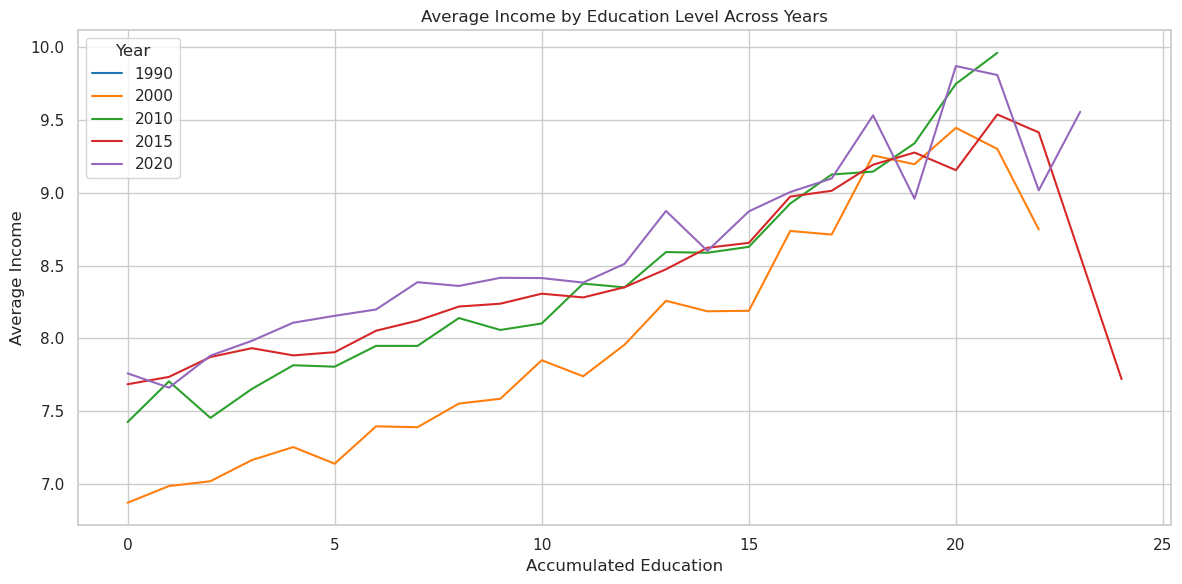

In [29]:
# Remove NaNs to avoid plot issues
avg_income_by_year_edu_clean = avg_income_by_year_edu.dropna()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_income_by_year_edu_clean,
             x='ESCOLARIDAD_ACUMULADA',
             y='LOG_INGRESO',
             hue='ANIO',
             palette='tab10')

plt.title("Average Income by Education Level Across Years")
plt.xlabel("Accumulated Education")
plt.ylabel("Average Income")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

I divide these variables into numerical and categorical. 

In [30]:
# ✅ Split into categorical and continuous variable lists
numerical_features = [
   # 'LOG_INGRESO',
    'ESCOLARIDAD_ACUMULADA',
    'EDAD'
]
categorical_features = [
    'MERCADO_TRABAJO_LOCAL',
    'LLAVE_TIETRASLADO_TRABAJO',
    'LLAVE_ACTPRIMARIA',
    'LLAVE_SITUACONYUGAL',
    'LLAVE_PERTEINDIGENA',
    'LLAVE_RELIGION',
    'LLAVE_AFRODES',
    'LLAVE_SEXO'
]

The number of categories in each of the variables is:


In [31]:
# Get categorical columns
categorical_features = train_data_selected.select_dtypes(include='category').columns

# Count number of unique categories for each categorical variable
category_counts = {col: train_data_selected[col].nunique() for col in categorical_features}
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Num Categories'])

# Sort by number of categories (optional)
category_counts_df = category_counts_df.sort_values(by='Num Categories', ascending=False)

# Display
print(category_counts_df)

                           Num Categories
MERCADO_TRABAJO_LOCAL                 724
LLAVE_RELIGION                         49
LLAVE_SITUACONYUGAL                    10
LLAVE_TIETRASLADO_TRABAJO               8
LLAVE_PERTEINDIGENA                     5
LLAVE_AFRODES                           5
ANIO                                    4
LLAVE_ACTPRIMARIA                       2
LLAVE_SEXO                              2


In [32]:
train_data_selected.columns

Index(['LOG_INGRESO', 'MERCADO_TRABAJO_LOCAL', 'ANIO',
       'LLAVE_TIETRASLADO_TRABAJO', 'LLAVE_ACTPRIMARIA',
       'ESCOLARIDAD_ACUMULADA', 'EDAD', 'LLAVE_SITUACONYUGAL',
       'LLAVE_PERTEINDIGENA', 'LLAVE_RELIGION', 'LLAVE_AFRODES', 'LLAVE_SEXO'],
      dtype='object')

### 🔧 Preprocessing Pipeline

To handle both numerical and categorical variables efficiently, we define separate pipelines and combine them using `ColumnTransformer` from Scikit-Learn:

There are two types of categorical variables, MERCADO_TRABAJO_LOCAL with a high number of categories (774) categories meanwhile the rest are with low to medium number of categories. To address each of these accordingly, I'll use Target Encoder for MERCADO_TRABAJO_LOCAL, and for the rest I'll use the hot encoder. 


To include these categorical variables in the regression i am going to transform them according to the number of categories that each variable has. 

For low-cardinality variables (≤ 10 categories) Use One-Hot Encoding
For Medium/high-cardinality variables (≫ 10 categories)
Instead, you can:
	•	Use Target Encoding (Mean Encoding)

In [33]:
high_card_cat = ['MERCADO_TRABAJO_LOCAL']
low_card_cat = list(set(categorical_features) - set(high_card_cat))


Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute:

Education has a high NA rate (~10%). so Im gonna  compute the median value on the training set and
use it to fill the missing values in the training set.


In [34]:
# ✅ Interaction variables (subset of numerical features)
interaction_features = ['ESCOLARIDAD_ACUMULADA', 'ANIO']

# ✅ All numerical features (you may include others here too)
# Make sure these include interaction_features
numerical_features = list(set(numerical_features + interaction_features))

# 🧮 Numerical pipeline with interaction AND power terms
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # includes powers + interactions
    ('scaler', StandardScaler())
])

# 🏷️ High-cardinality categorical pipeline
high_card_pipeline = Pipeline([
    ('target_encoder', TargetEncoder())
])

# 🏷️ Low-cardinality categorical pipeline
low_card_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# 🔧 Full preprocessing pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('low_card', low_card_pipeline, low_card_cat),
    ('high_card', high_card_pipeline, high_card_cat)
])

In [35]:
# Separate features and target
X_train = train_data_selected.drop(columns=['LOG_INGRESO'])
y_train = train_data_selected['LOG_INGRESO']

# Fit the full pipeline and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train, y_train)

# Now that the pipeline is fitted, extract feature names
feature_names = full_pipeline.get_feature_names_out()

## Analysis

Let’s first train a Linear Regression model, like
we did in the previous chapter:

This model is just a linear function of the input feature GDP_per_capita. θ0 and θ1 are
the model’s parameters.
More generally, a linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the bias term (also called the intercept
term), as shown in Equation 4-1.

In [109]:
# 1. Define and evaluate the model
model = LinearRegression()

# 2. Cross-validation
mse_scores = cross_val_score(model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -mse_scores  # Convert to positive

mean_mse = mse_scores.mean()
variance_mse = mse_scores.var()

print(f"🔁 Cross-validated Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"📉 Variance of MSE: {variance_mse:.6f}")

# 3. Retrain on the full training set
model.fit(X_train_prepared, y_train)

# 4. Extract and display the coefficients
coefficients = model.coef_
feature_names = full_pipeline.get_feature_names_out()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values("Abs_Coefficient", ascending=False)

print("\n📌 Top 10 most impactful features:")
print(coef_df_sorted.head(10))

🔁 Cross-validated Mean Squared Error (MSE): 0.4850
📉 Variance of MSE: 0.001327

📌 Top 10 most impactful features:
                             Feature  Coefficient  Abs_Coefficient
5    num__ESCOLARIDAD_ACUMULADA ANIO   -21.819453        21.819453
0         num__ESCOLARIDAD_ACUMULADA    21.627218        21.627218
1                          num__EDAD     7.602137         7.602137
7                     num__EDAD ANIO    -7.312262         7.312262
83       low_card__LLAVE_RELIGION_89    -1.720572         1.720572
56       low_card__LLAVE_RELIGION_18    -1.429156         1.429156
82       low_card__LLAVE_RELIGION_88    -1.134065         1.134065
94  high_card__MERCADO_TRABAJO_LOCAL     1.063150         1.063150
75       low_card__LLAVE_RELIGION_63    -0.897355         0.897355
68       low_card__LLAVE_RELIGION_31    -0.848374         0.848374


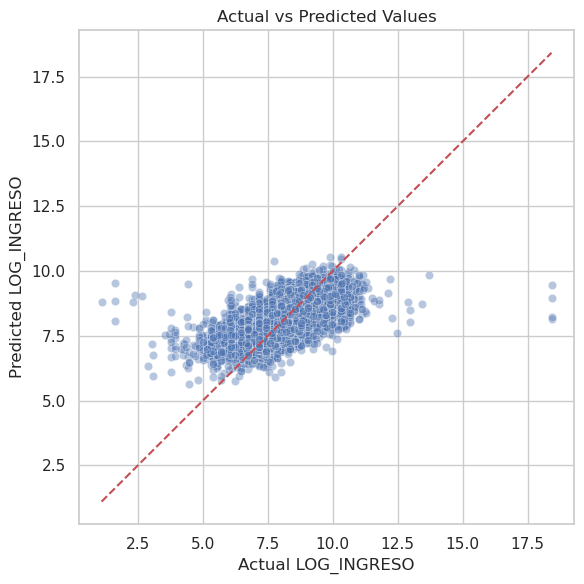

In [110]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual LOG_INGRESO")
plt.ylabel("Predicted LOG_INGRESO")
plt.title("Actual vs Predicted Values")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

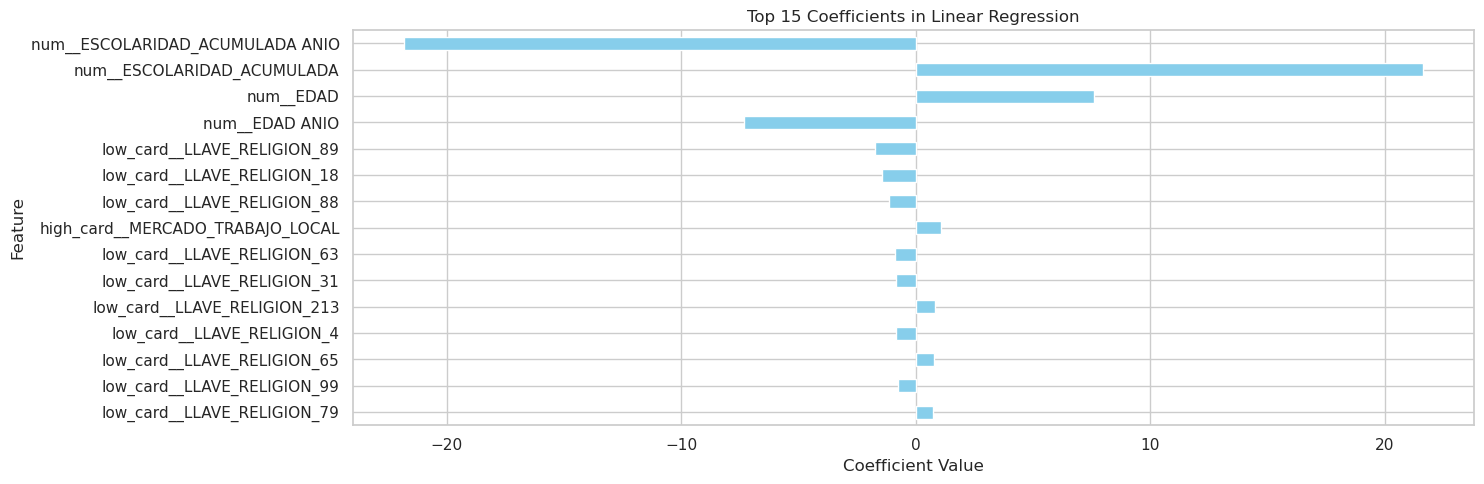

In [112]:
top_n = 15  # Adjust this if you want more/less

plt.figure(figsize=(10, 6))
coef_df_sorted.head(top_n).plot(
    kind='barh', 
    x='Feature', 
    y='Coefficient', 
    color='skyblue', 
    legend=False
)
plt.title(f"Top {top_n} Coefficients in Linear Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

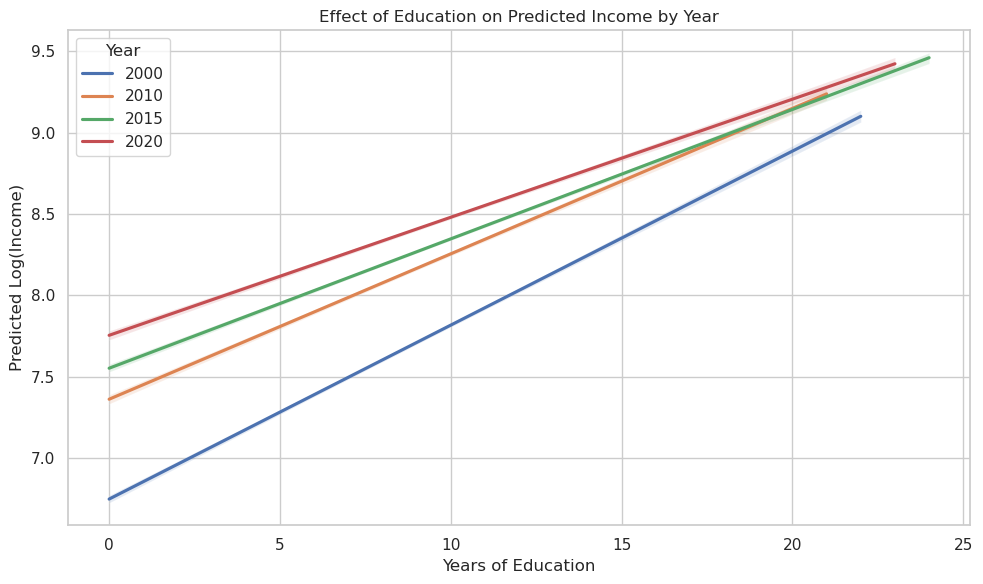

In [113]:
# Reconstruct the original features if needed
X_train_df = pd.DataFrame(X_train_prepared.toarray(), columns=feature_names)

# Add predictions and original features
X_vis = X_train.copy()
X_vis['Predicted_LOG_INGRESO'] = model.predict(X_train_prepared)

# Group years to avoid overplotting (you can change this)
years_to_plot = sorted(X_vis['ANIO'].unique())[-5:]  # Last 5 years

# Plot
plt.figure(figsize=(10, 6))
for year in years_to_plot:
    subset = X_vis[X_vis['ANIO'] == year]
    sns.regplot(data=subset, x='ESCOLARIDAD_ACUMULADA', y='Predicted_LOG_INGRESO', label=str(year), scatter=False)

plt.title("Effect of Education on Predicted Income by Year")
plt.xlabel("Years of Education")
plt.ylabel("Predicted Log(Income)")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

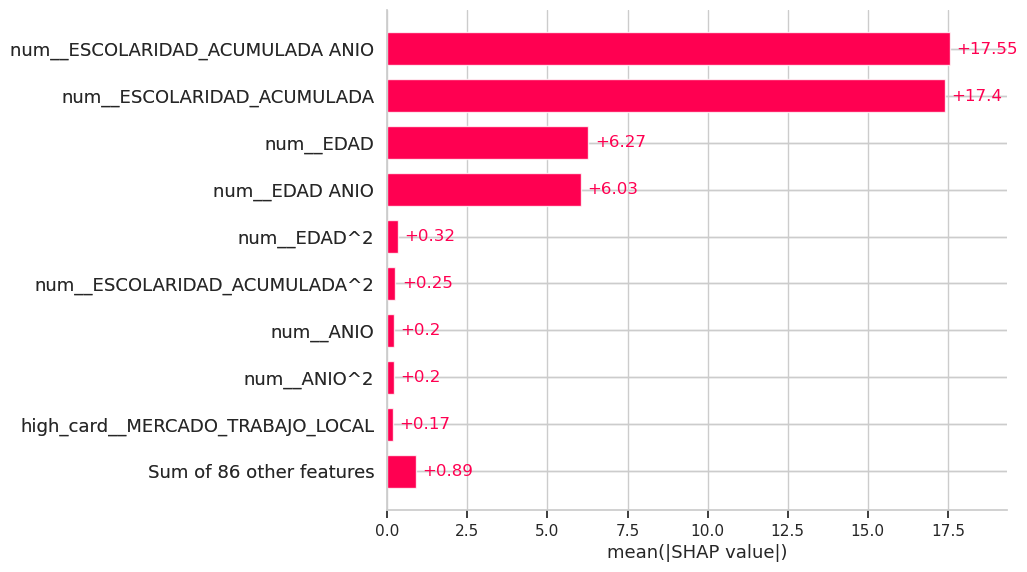

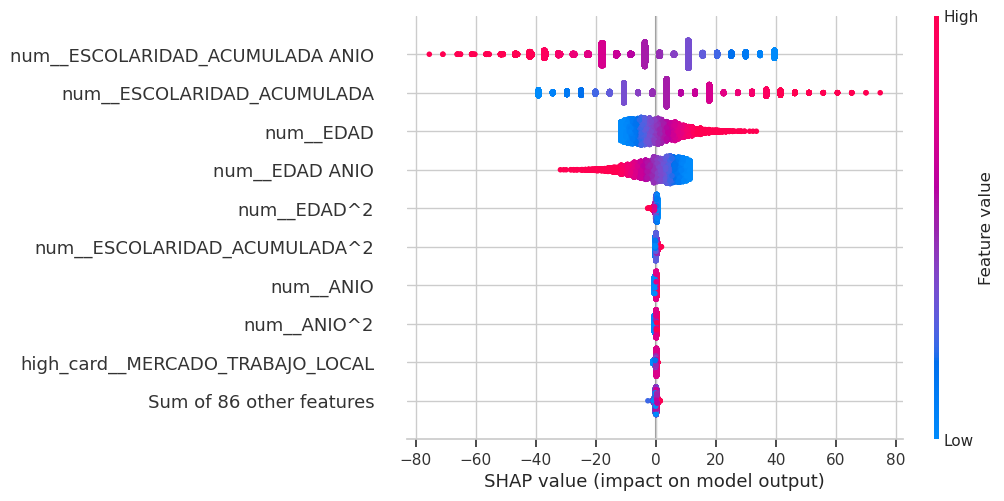

In [ ]:
# ✅ SHAP explainer for Linear Regression
explainer = shap.LinearExplainer(model, X_train_prepared, feature_perturbation="interventional")

# ✅ Compute SHAP values
shap_values = explainer(X_train_prepared)

# ✅ Use feature names in plot
shap_values.feature_names = full_pipeline.get_feature_names_out().tolist()

# ✅ SHAP bar plot with feature names
shap.plots.bar(shap_values, max_display=15)

# (Optional) SHAP beeswarm with names
shap.plots.beeswarm(shap_values, max_display=15)

Regularized Linear Models

A simple way to regularize a polynomial model is to reduce
the number of polynomial degrees.
For a linear model, regularization is typically achieved by constraining the weights of
the model. We will now look at Ridge Regression, Lasso Regression, 

Lasso

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).


Lasso (Least Absolute Shrinkage and Selection Operator):
	•	Performs linear regression with L1 regularization
	•	Penalizes large coefficients
	•	Drives some coefficients to exactly zero, performing feature selection

This is why it’s great for identifying the most important variables—unlike Ridge, Lasso can remove irrelevant ones entirely.

⸻



In [96]:
# ✅ Fit LassoCV with more iterations
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_prepared, y_train)

# 🔢 Best regularization strength
print(f"✅ Best alpha (λ): {lasso.alpha_:.5f}")

# 📊 MSE and variance
y_pred = lasso.predict(X_train_prepared)
mse = mean_squared_error(y_train, y_pred)
variance = np.var((y_train - y_pred) ** 2)

print(f"📉 Lasso MSE: {mse:.4f}")
print(f"📉 Variance of prediction errors: {variance:.6f}")

/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.152651115658955, tolerance: 1.1200002937775073
  model = cd_fast.sparse_enet_coordinate_descent(
/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2009254374988814, tolerance: 1.130919567542444
  model = cd_fast.sparse_enet_coordinate_descent(
/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1873199413230395, tolerance: 1.151732078076371
  model = cd_fast.sparse_enet_coordi

✅ Best alpha (λ): 0.00041
📉 Lasso MSE: 0.4873
📉 Variance of prediction errors: 4.214924


/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.478885192609596, tolerance: 1.4232477372926446
  model = cd_fast.sparse_enet_coordinate_descent(


In [97]:
# 📎 Get coefficients
feature_names = full_pipeline.get_feature_names_out()
lasso_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lasso.coef_
})
nonzero = lasso_coef_df[lasso_coef_df["Coefficient"] != 0]
print(f"🧹 Non-zero coefficients: {len(nonzero)} out of {len(feature_names)}")


🧹 Non-zero coefficients: 37 out of 95


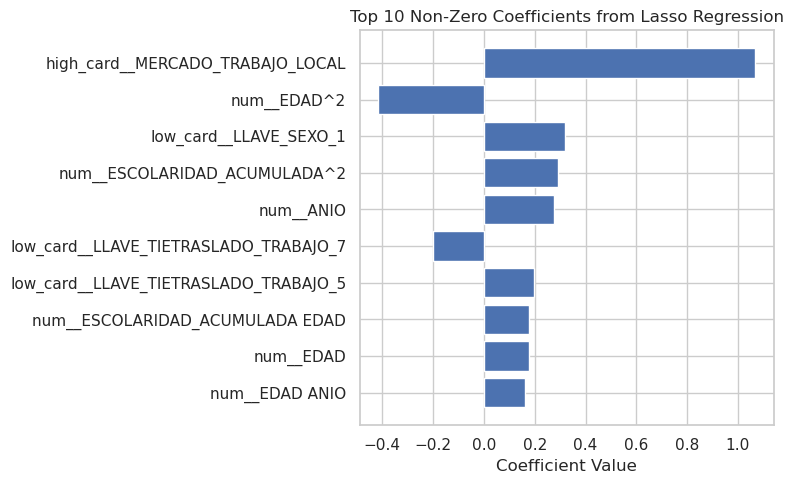

In [98]:
# 📊 Visualize top coefficients
top = nonzero.reindex(nonzero.Coefficient.abs().sort_values(ascending=False).index).head(10)

plt.figure(figsize=(8, 5))
plt.barh(top["Feature"], top["Coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Top 10 Non-Zero Coefficients from Lasso Regression")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

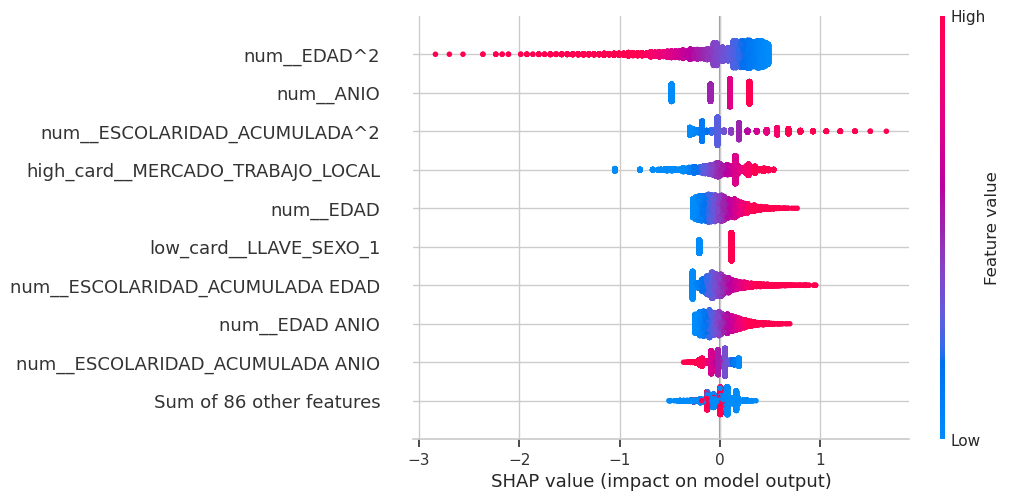

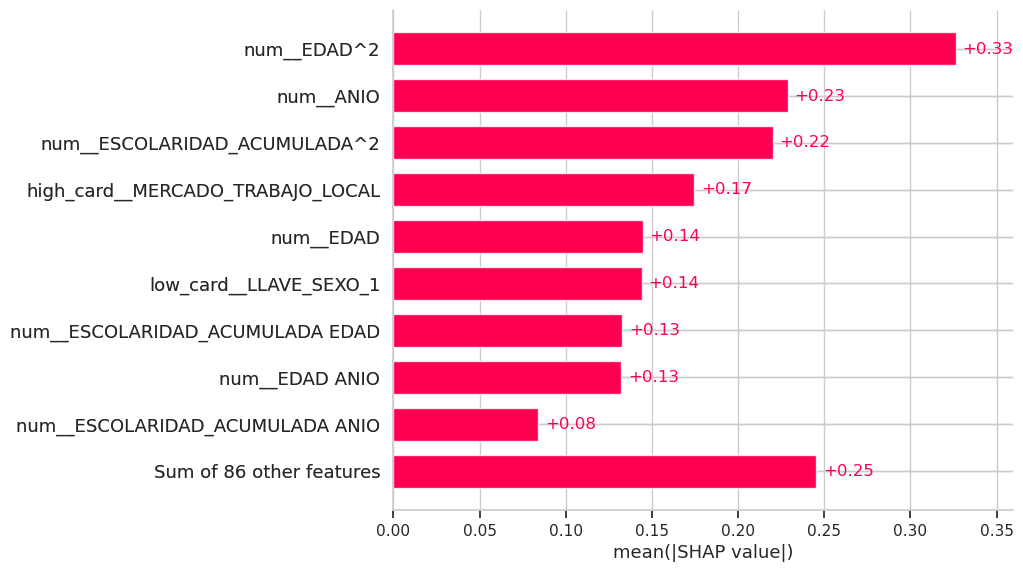

In [ ]:
# Choose model (already fitted)
model = lasso  # or ridge

# SHAP Explainer for linear models
explainer = shap.Explainer(model, X_train_prepared, feature_names=feature_names, algorithm="linear")

# Compute SHAP values
shap_values = explainer(X_train_prepared)

# 📊 Summary plot (top features by mean absolute SHAP value)
shap.plots.beeswarm(shap_values, max_display=15)

# Optional: Bar plot summary
shap.plots.bar(shap_values, max_display=15)

Ridge 

Ridge Regression is a great next step. It’s similar to Lasso, but instead of eliminating features (like Lasso does), it shrinks all coefficients—especially helpful when you have multicollinearity or highly correlated predictors.

✅ What Ridge does:
	•	Performs L2 regularization, which reduces the size of coefficients but does not force them to zero
	•	Stabilizes the model when you have many correlated features (like polynomial and interaction terms)
	•	Is often more stable than Lasso when your predictors are highly collinear

⸻


In [91]:
# ✅ Fit RidgeCV with cross-validation
alphas = np.logspace(-6, 2, 100)  # Try a wide range of alpha values
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_prepared, y_train)

# 🔢 Best regularization strength
print(f"✅ Best alpha (λ): {ridge.alpha_:.5f}")

# 📊 MSE and variance
y_pred = ridge.predict(X_train_prepared)
mse = mean_squared_error(y_train, y_pred)
variance = np.var((y_train - y_pred) ** 2)

print(f"📉 Ridge MSE: {mse:.4f}")
print(f"📉 Variance of prediction errors: {variance:.6f}")

✅ Best alpha (λ): 0.00000
📉 Ridge MSE: 0.4803
📉 Variance of prediction errors: 4.143969


✅ Full Code to Display Top Coefficients in Ridge Regression

In [93]:
# 🔍 Extract coefficients and feature names
ridge_coefficients = ridge.coef_
feature_names = full_pipeline.get_feature_names_out()

# 🧾 Create DataFrame of coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge_coefficients
})
coef_df["Abs"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values("Abs", ascending=False).head(15)



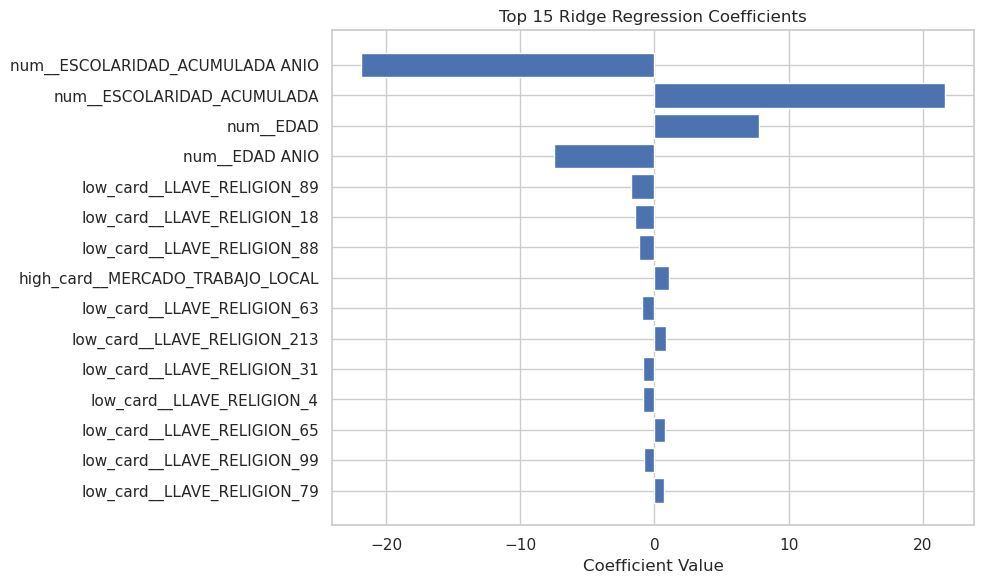

In [94]:
# 📊 Bar plot of top coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 15 Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

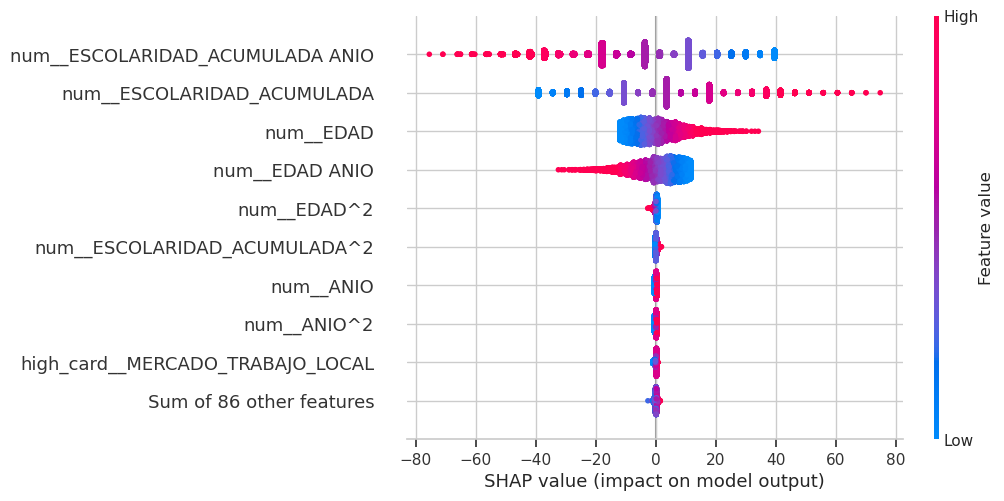

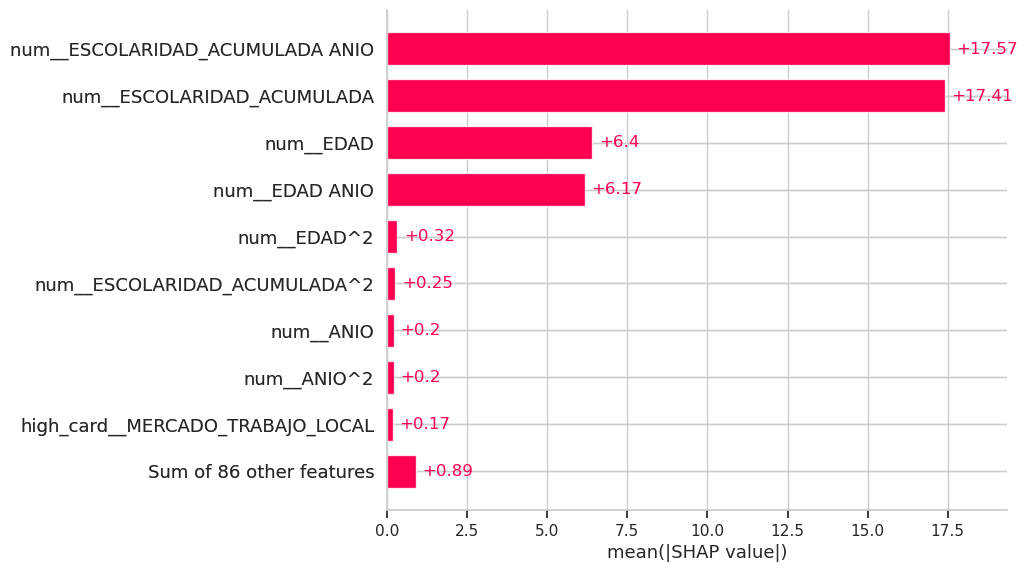

In [ ]:
# Choose model (already fitted)
model = ridge  # or ridge

# SHAP Explainer for linear models
explainer = shap.Explainer(model, X_train_prepared, feature_names=feature_names, algorithm="linear")

# Compute SHAP values
shap_values = explainer(X_train_prepared)

# 📊 Summary plot (top features by mean absolute SHAP value)
shap.plots.beeswarm(shap_values, max_display=15)

# Optional: Bar plot summary
shap.plots.bar(shap_values, max_display=15)

Random Forest regressor

A Random Forest Regressor is a machine learning model used for predicting continuous values (i.e., for regression problems). It works by combining the results of many decision trees to produce a more accurate and stable prediction.

	•	Instead of relying on one decision tree (which may overfit the data), Random Forest builds many trees (each trained on a random subset of the data and features).
	•	Each tree gives a regression output (a number), and the forest averages all outputs to make the final prediction.


In [130]:
# Instantiate model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation
rf_scores = cross_val_score(rf_model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_var = rf_scores.var()

print(f"🌲 Random Forest MSE: {rf_mse:.4f}")
print(f"📉 Variance of MSE: {rf_var:.6f}")

# Fit full model
rf_model.fit(X_train_prepared, y_train)



🌲 Random Forest MSE: 0.5285
📉 Variance of MSE: 0.001775


RandomForestRegressor(random_state=42)

In [135]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
feature_names = full_pipeline.get_feature_names_out()

# Create a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show the top 15
print(importance_df.head(15))

                                  Feature  Importance
5         num__ESCOLARIDAD_ACUMULADA ANIO    0.231568
94       high_card__MERCADO_TRABAJO_LOCAL    0.222500
4         num__ESCOLARIDAD_ACUMULADA EDAD    0.094569
7                          num__EDAD ANIO    0.062647
33                    low_card__ANIO_2000    0.054103
1                               num__EDAD    0.035898
6                             num__EDAD^2    0.035132
25                 low_card__LLAVE_SEXO_2    0.018105
24                 low_card__LLAVE_SEXO_1    0.016175
17        low_card__LLAVE_SITUACONYUGAL_8    0.015459
10        low_card__LLAVE_SITUACONYUGAL_1    0.012949
3            num__ESCOLARIDAD_ACUMULADA^2    0.011203
44  low_card__LLAVE_TIETRASLADO_TRABAJO_7    0.010831
18        low_card__LLAVE_SITUACONYUGAL_9    0.010415
0              num__ESCOLARIDAD_ACUMULADA    0.010033


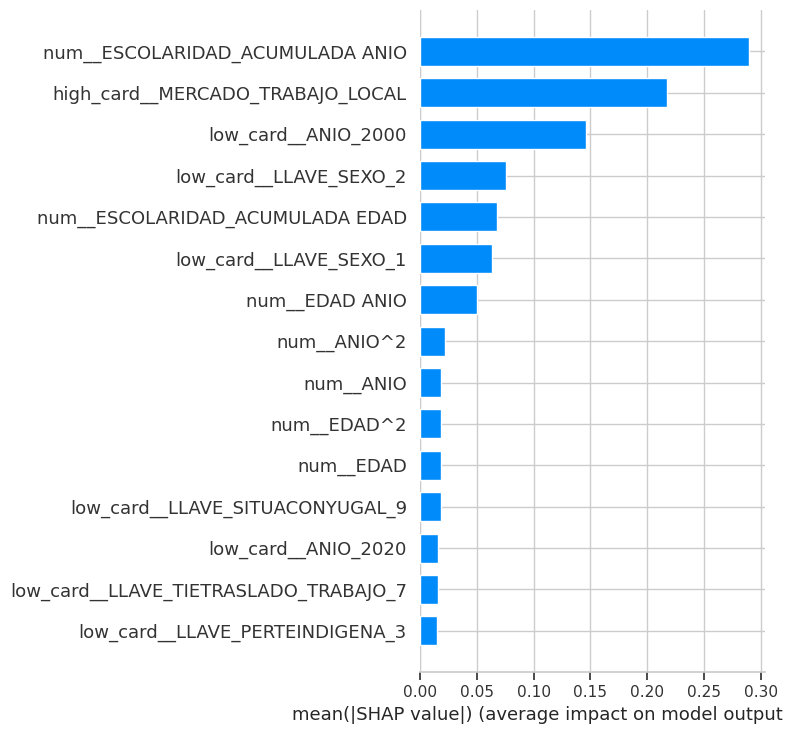

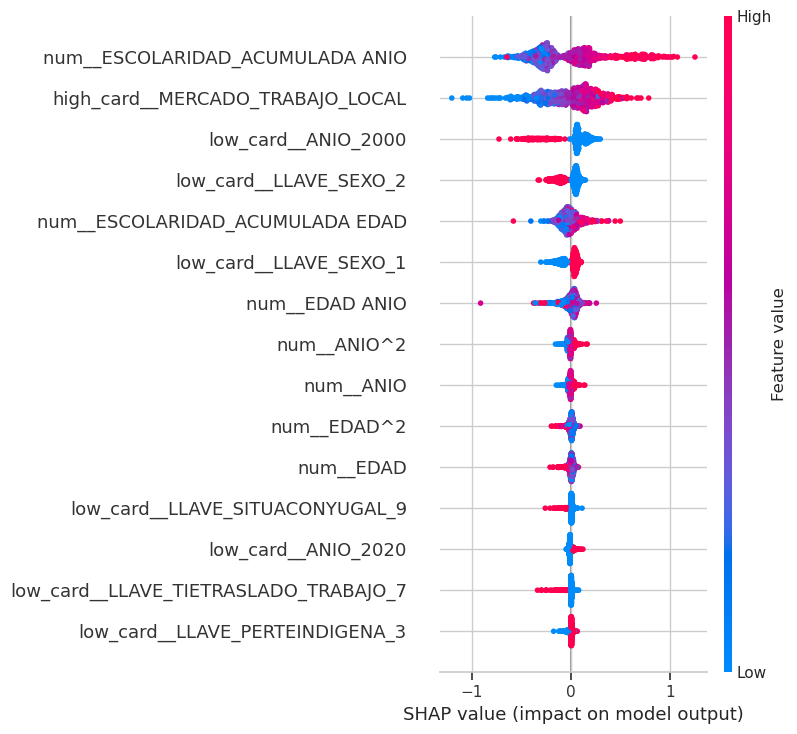

In [134]:
# ⚡ Use a representative sample (e.g., 1000 rows)
sample_idx = np.random.choice(X_train_prepared.shape[0], size=1000, replace=False)

# ✅ Ensure dense and numeric format
X_dense = X_train_prepared.toarray() if hasattr(X_train_prepared, "toarray") else X_train_prepared
X_sample = X_dense[sample_idx].astype(np.float64)  # Ensure float64 dtype

# 🧠 Create TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# 🧮 Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 🏷️ Feature names
feature_names = full_pipeline.get_feature_names_out()

# 📊 Bar plot (summary)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", max_display=15)

# 🐝 Beeswarm plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=15)

Gradient Boosting Regression

Instead of training one big model like linear regression or a single decision tree, Gradient Boosting builds a series of small decision trees, one after the other.
2. Learns from mistakes:
Each new tree is trained to correct the errors made by the previous trees. It’s like each new model says:
“Hey, what did the last model miss? Let me fix that.”

3. Focuses on the hardest parts:
By giving more attention to the data points that were predicted badly, it improves overall accuracy step by step.

4. Combines all the trees:
At the end, it adds up all the small corrections from each tree to make a strong final prediction.

In [136]:
# Instantiate model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Cross-validation
gb_scores = cross_val_score(gb_model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')
gb_mse = -gb_scores.mean()
gb_var = gb_scores.var()

print(f"🔥 Gradient Boosting MSE: {gb_mse:.4f}")
print(f"📉 Variance of MSE: {gb_var:.6f}")

# Fit full model
gb_model.fit(X_train_prepared, y_train)

🔥 Gradient Boosting MSE: 0.4803
📉 Variance of MSE: 0.001347


GradientBoostingRegressor(random_state=42)

In [143]:
# Get feature importances from the model
importances = gb_model.feature_importances_

# Get feature names from preprocessing pipeline
feature_names = full_pipeline.get_feature_names_out()

# Create DataFrame with importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort by importance (descending)
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False)

# Display top features
print("📌 Top 15 most important features in Gradient Boosting:")
print(importance_df_sorted.head(15))



📌 Top 15 most important features in Gradient Boosting:
                                  Feature  Importance
5         num__ESCOLARIDAD_ACUMULADA ANIO    0.372308
94       high_card__MERCADO_TRABAJO_LOCAL    0.186510
4         num__ESCOLARIDAD_ACUMULADA EDAD    0.129582
33                    low_card__ANIO_2000    0.056760
2                               num__ANIO    0.048214
8                             num__ANIO^2    0.039947
24                 low_card__LLAVE_SEXO_1    0.034497
7                          num__EDAD ANIO    0.030598
25                 low_card__LLAVE_SEXO_2    0.030233
36                    low_card__ANIO_2020    0.011824
44  low_card__LLAVE_TIETRASLADO_TRABAJO_7    0.010986
22        low_card__LLAVE_PERTEINDIGENA_3    0.009368
18        low_card__LLAVE_SITUACONYUGAL_9    0.007750
6                             num__EDAD^2    0.005875
1                               num__EDAD    0.005645


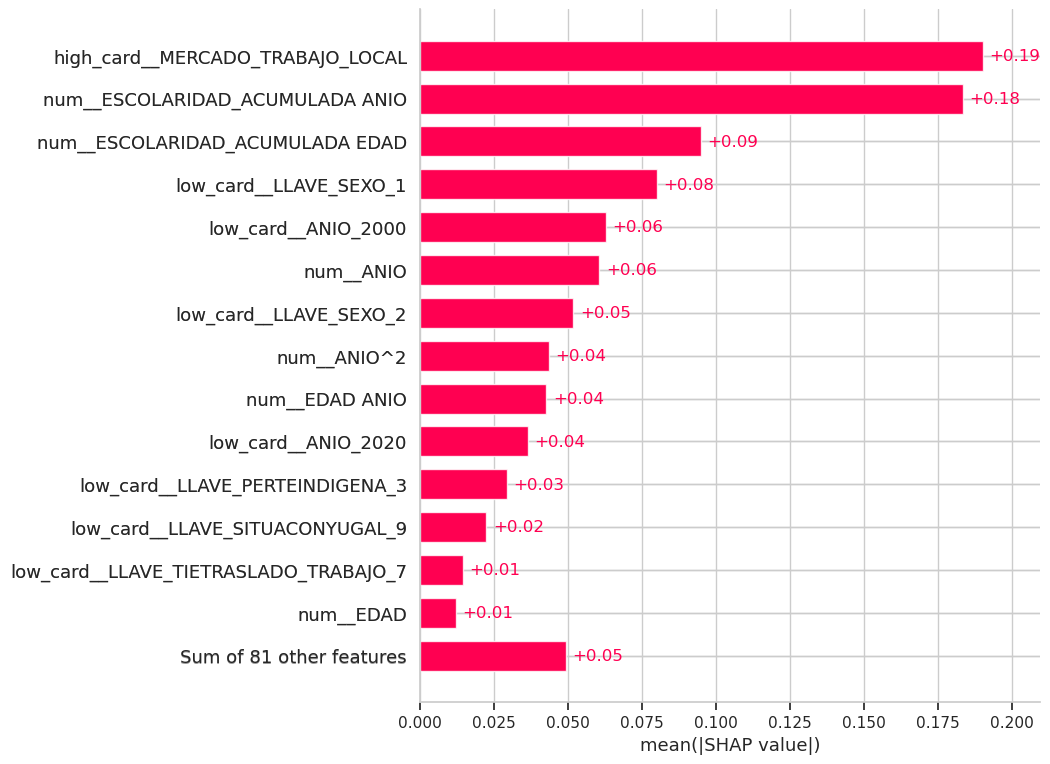

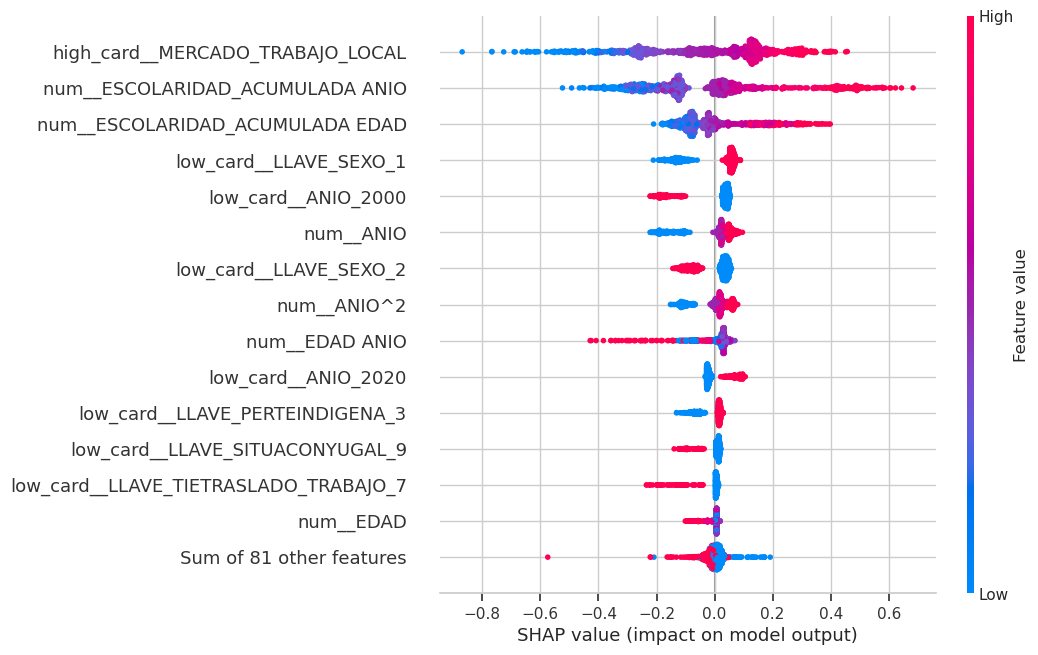

In [141]:
# ⚡ Sample from the training data
sample_idx = np.random.choice(X_train_prepared.shape[0], size=1000, replace=False)
X_sample_sparse = X_train_prepared[sample_idx]

# 🔧 Convert sparse matrix to dense and ensure float format
X_sample = X_sample_sparse.toarray().astype(np.float64)

# 🧠 Create the SHAP explainer (with feature names)
explainer = shap.Explainer(gb_model, X_sample, feature_names=feature_names)

# 📊 Compute SHAP values
shap_values = explainer(X_sample)

# ✅ SHAP bar plot
shap.plots.bar(shap_values, max_display=15)

# 🐝 SHAP beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)